# Improved GNN Movie Recommender

Key Improvements Over Previous Versions

- ✅ Correct loss formulation

Trained only on observed ratings (no unobserved entries in loss).

Ensures fair comparison with classical MF and TensorFlow baseline.

- ✅ Bias-aware prediction model

Explicit user bias + movie bias + global mean.

Allows the model to capture systematic rating tendencies independently of embeddings.

- ✅ Consistent rating handling

Training performed on raw ratings, matching the prediction formula.

Rating normalization is computed for analysis but not incorrectly mixed into training.

- ✅ Graph construction fixed

Graph built only from training interactions.

Cold-start movies removed from test set via movie-safe split.

- ✅ Proper regularization

L2 regularization applied to embedding tables (MF) and bias/scale terms (GCN variants).

Prevents overfitting while preserving expressive embeddings.

- ✅ Meaningful similarity evaluation

Switched from raw dot product to cosine similarity.

Embeddings now produce semantically reasonable neighbors.

**Prediction Formula (Matches TensorFlow Reference)**

        prediction = X @ Wᵀ + user_bias + movie_bias + global_mean

This formulation is now identical in spirit and behavior to the original TensorFlow implementation.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch_geometric.nn import GCNConv, SAGEConv, LGConv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

print("Libraries loaded!")

Libraries loaded!


---
## Part 1: Load and Prepare Data

In [2]:
# Load MovieLens data
df_ratings = pd.read_csv('/Users/pelinbalci/PycharmProjects/MovieRecommendation/data/ml-latest-small/ratings.csv')
df_movies = pd.read_csv('/Users/pelinbalci/PycharmProjects/MovieRecommendation/data/ml-latest-small/movies.csv')

print(f"Total ratings: {len(df_ratings)}")
print(f"Users: {df_ratings['userId'].nunique()}")
print(f"Movies: {df_ratings['movieId'].nunique()}")
print(f"Rating range: {df_ratings['rating'].min()} - {df_ratings['rating'].max()}")
print(f"Average rating: {df_ratings['rating'].mean():.4f}")

Total ratings: 100836
Users: 610
Movies: 9724
Rating range: 0.5 - 5.0
Average rating: 3.5016


In [3]:
# Create ID mappings
unique_users = sorted(df_ratings['userId'].unique())
unique_movies = sorted(df_ratings['movieId'].unique())

user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
movie_to_idx = {movie: idx for idx, movie in enumerate(unique_movies)}
idx_to_user = {idx: user for user, idx in user_to_idx.items()}
idx_to_movie = {idx: movie for movie, idx in movie_to_idx.items()}

num_users = len(unique_users)
num_movies = len(unique_movies)
num_nodes = num_users + num_movies

print(f"num_users: {num_users}")
print(f"num_movies: {num_movies}")
print(f"num_nodes: {num_nodes}")

num_users: 610
num_movies: 9724
num_nodes: 10334


In [4]:
# Convert to indices
user_indices = np.array([user_to_idx[u] for u in df_ratings['userId']])
movie_indices = np.array([movie_to_idx[m] for m in df_ratings['movieId']])
ratings = df_ratings['rating'].values.astype(np.float32)

print(f"Data shapes: users {user_indices.shape}, movies {movie_indices.shape}, ratings {ratings.shape}")

Data shapes: users (100836,), movies (100836,), ratings (100836,)


---
## Part 2: Calculate Global Mean and Normalize Ratings


```python
Ymean = (np.sum(Y * R, axis=1) / (np.sum(R, axis=1) + 1e-12)).reshape(-1, 1)
Ynorm = Y - np.multiply(Ymean, R)
```

In [5]:
# Calculate GLOBAL mean (average of all ratings)
global_mean = ratings.mean()
print(f"Global mean rating: {global_mean:.4f}")

# Calculate per-movie mean
movie_rating_sum = np.zeros(num_movies)
movie_rating_count = np.zeros(num_movies)

for m_idx, r in zip(movie_indices, ratings):
    movie_rating_sum[m_idx] += r
    movie_rating_count[m_idx] += 1

# Avoid division by zero - use global mean for movies with no ratings
movie_means = np.where(
    movie_rating_count > 0,
    movie_rating_sum / movie_rating_count,
    global_mean
)

print(f"Movie means range: {movie_means.min():.2f} - {movie_means.max():.2f}")

# Normalize ratings: subtract movie mean (like your TF code)
ratings_normalized = ratings - movie_means[movie_indices]

print(f"Normalized ratings range: {ratings_normalized.min():.2f} to {ratings_normalized.max():.2f}")
print(f"Normalized ratings mean: {ratings_normalized.mean():.6f} (should be ~0)")

Global mean rating: 3.5016
Movie means range: 0.50 - 5.00
Normalized ratings range: -3.77 to 3.07
Normalized ratings mean: 0.000000 (should be ~0)


In [6]:
# Train/Test split
train_idx, test_idx = train_test_split(
    np.arange(len(ratings)), 
    test_size=0.2, 
    random_state=42
)

# Training data
train_users = user_indices[train_idx]
train_movies = movie_indices[train_idx]
train_ratings = ratings[train_idx]
train_ratings_norm = ratings_normalized[train_idx]

# Test data  
test_users = user_indices[test_idx]
test_movies = movie_indices[test_idx]
test_ratings = ratings[test_idx]
test_ratings_norm = ratings_normalized[test_idx]

print(f"Training samples: {len(train_idx)}")
print(f"Test samples: {len(test_idx)}")

Training samples: 80668
Test samples: 20168


In [7]:
train_users

array([508, 325,  56, ..., 479,   5, 102], shape=(80668,))

In [8]:
train_movies

array([4893, 7127, 1575, ..., 4601,  748, 4522], shape=(80668,))

Let's check the train test split:

In [9]:
train_user_set = set(train_users.tolist())
test_user_set = set(test_users.tolist())
cold_users = len([u for u in test_user_set if u not in train_user_set])

train_movie_set = set(train_movies.tolist())
test_movie_set = set(test_movies.tolist())
cold_movies = len([m for m in test_movie_set if m not in train_movie_set])

print("Cold-start users in test:", cold_users)
print("Cold-start movies in test:", cold_movies)

Cold-start users in test: 0
Cold-start movies in test: 741


There are so many movies which are not in the training set. So we need another method for train test split to prevent cold start:

In [10]:
from sklearn.model_selection import train_test_split
import numpy as np

# ------------------------------------------------------------------
# MOVIE-SAFE SPLIT: every movie appears in TRAIN at least once
# ------------------------------------------------------------------

num_ratings = len(ratings)

# Collect rating indices per movie
movie_to_rating_indices = {}
for i, m in enumerate(movie_indices):
    movie_to_rating_indices.setdefault(m, []).append(i)

train_idx = []
remaining_idx = []

# Step 1: force 1 rating per movie into TRAIN
for m, idxs in movie_to_rating_indices.items():
    train_idx.append(idxs[0])        # guaranteed train
    remaining_idx.extend(idxs[1:])   # rest go to pool

train_idx = np.array(train_idx)
remaining_idx = np.array(remaining_idx)

# Step 2: split remaining ratings normally
train_extra_idx, test_idx = train_test_split(
    remaining_idx,
    test_size=0.2,
    random_state=42
)

train_idx = np.concatenate([train_idx, train_extra_idx])

# ------------------------------------------------------------------
# Build final train / test arrays (THIS MATCHES YOUR PIPELINE)
# ------------------------------------------------------------------

train_users = user_indices[train_idx]
train_movies = movie_indices[train_idx]
train_ratings = ratings[train_idx]
train_ratings_norm = ratings_normalized[train_idx]

test_users = user_indices[test_idx]
test_movies = movie_indices[test_idx]
test_ratings = ratings[test_idx]
test_ratings_norm = ratings_normalized[test_idx]

print(f"Training samples: {len(train_users)}")
print(f"Test samples: {len(test_users)}")

# Sanity check: NO cold-start movies
cold_movies = set(test_movies) - set(train_movies)
print("Cold-start movies in test:", len(cold_movies))


Training samples: 82613
Test samples: 18223
Cold-start movies in test: 0


In [11]:
assert len(set(test_movies) - set(train_movies)) == 0

---
## Part 3: Build Graph with Edge Weights

In [12]:
# Build edge index
train_users_t = torch.tensor(train_users, dtype=torch.long)
train_movies_t = torch.tensor(train_movies, dtype=torch.long)

# Movie node indices (shifted by num_users)
movie_node_indices = train_movies_t + num_users

# Bidirectional edges
edge_index = torch.stack([
    torch.cat([train_users_t, movie_node_indices]),
    torch.cat([movie_node_indices, train_users_t])
], dim=0)

# Edge weights: rating values normalized to 0-1
train_ratings_for_weights = torch.tensor(train_ratings, dtype=torch.float32)
edge_weights = train_ratings_for_weights / 5.0
edge_weights = torch.cat([edge_weights, edge_weights])  # Bidirectional

print(f"edge_index shape: {edge_index.shape}")
print(f"edge_weights shape: {edge_weights.shape}")
print(f"edge_weights range: {edge_weights.min():.2f} - {edge_weights.max():.2f}")

edge_index shape: torch.Size([2, 165226])
edge_weights shape: torch.Size([165226])
edge_weights range: 0.10 - 1.00


In [13]:
# Convert to tensors
train_users_t = torch.tensor(train_users, dtype=torch.long)
train_movies_t = torch.tensor(train_movies, dtype=torch.long)
train_ratings_t = torch.tensor(train_ratings, dtype=torch.float32)
train_ratings_norm_t = torch.tensor(train_ratings_norm, dtype=torch.float32)

test_users_t = torch.tensor(test_users, dtype=torch.long)
test_movies_t = torch.tensor(test_movies, dtype=torch.long)
test_ratings_t = torch.tensor(test_ratings, dtype=torch.float32)

# Store means as tensors
movie_means_t = torch.tensor(movie_means, dtype=torch.float32)
global_mean_t = torch.tensor(global_mean, dtype=torch.float32)

print(f"Global mean: {global_mean_t.item():.4f}")
print("Data tensors ready!")

Global mean: 3.5016
Data tensors ready!


---
## Part 4: Model Definitions

**Key: All models now include global_mean in prediction!**

```
prediction = dot(user, movie) + user_bias + movie_bias + global_mean
```

This matches your TensorFlow code:
```python
p = np.matmul(X.numpy(), np.transpose(W.numpy())) + b.numpy()
pm = p + Ymean  # restore the mean
```

### Model 1: Improved Matrix Factorization

In [14]:
class ImprovedMF(nn.Module):
    """
    Matrix Factorization matching your TensorFlow code exactly.
    
    TensorFlow: prediction = X @ W.T + b + Ymean
    PyTorch:    prediction = user_emb · movie_emb + user_b + movie_b + global_mean
    """
    
    def __init__(self, num_users, num_movies, embedding_dim, global_mean):
        super().__init__()
        
        self.num_users = num_users
        self.num_movies = num_movies
        
        # Embeddings (like X and W in your code)
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        
        # Bias terms (like b in your code)
        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)
        
        # Global mean (like Ymean in your code) - NOT learnable
        self.register_buffer('global_mean', torch.tensor([global_mean], dtype=torch.float32))
        
        # Initialize
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.movie_embedding.weight)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.movie_bias.weight)
    
    def forward(self, edge_index, user_idx, movie_idx, edge_weight=None):
        # Get embeddings
        user_emb = self.user_embedding(user_idx)
        movie_emb = self.movie_embedding(movie_idx)
        
        # Dot product (like X @ W.T)
        dot = (user_emb * movie_emb).sum(dim=1)
        
        # Add bias terms (like + b)
        user_b = self.user_bias(user_idx).view(-1)
        movie_b = self.movie_bias(movie_idx).view(-1)
        
        # Full prediction (like + Ymean)
        prediction = dot + user_b + movie_b + self.global_mean
        
        return prediction
    
    def get_regularization_loss(self, lambda_=0.01):
        """L2 regularization: lambda * (||X||² + ||W||²)"""
        reg = lambda_ * (
            self.user_embedding.weight.norm(2).pow(2) +
            self.movie_embedding.weight.norm(2).pow(2)
        )
        return reg

print("✅ ImprovedMF defined")

✅ ImprovedMF defined


### Model 2: Improved GCN

In [15]:
class ImprovedGCN(nn.Module):
    """GCN recommender (train-graph propagation, bias terms, stable scaling)."""

    def __init__(self, num_users, num_movies, embedding_dim, global_mean, dropout=0.2):
        super().__init__()

        self.num_users = num_users
        self.num_movies = num_movies
        self.dropout = dropout

        num_nodes = num_users + num_movies

        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        nn.init.xavier_uniform_(self.embedding.weight)

        self.conv1 = GCNConv(embedding_dim, embedding_dim, add_self_loops=True, normalize=True)
        self.conv2 = GCNConv(embedding_dim, embedding_dim, add_self_loops=True, normalize=True)

        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.movie_bias.weight)

        self.register_buffer('global_mean', torch.tensor([global_mean], dtype=torch.float32))

        # Positive scale for dot product (scale = exp(log_scale))
        self.log_scale = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))

    def forward(self, edge_index, user_idx, movie_idx, edge_weight=None):
        # IMPORTANT: do NOT use rating values as edge weights for message passing
        x = self.embedding.weight

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        # No ReLU here: allow negative components for similarity
        x = F.dropout(x, p=self.dropout, training=self.training)

        user_embeddings = x[:self.num_users]
        movie_embeddings = x[self.num_users:]

        user_emb = user_embeddings[user_idx]
        movie_emb = movie_embeddings[movie_idx]

        dot = (user_emb * movie_emb).sum(dim=1) * torch.exp(self.log_scale)

        user_b = self.user_bias(user_idx).view(-1)
        movie_b = self.movie_bias(movie_idx).view(-1)

        return dot + user_b + movie_b + self.global_mean

    def get_regularization_loss(self, lambda_b=1e-4, lambda_s=1e-4):
        b = self.user_bias.weight.pow(2).sum() + self.movie_bias.weight.pow(2).sum()
        s = self.log_scale.pow(2).sum()
        return lambda_b * b + lambda_s * s


### Model 3: Improved GraphSAGE

In [16]:
class ImprovedGraphSAGE(nn.Module):
    """GraphSAGE recommender (train-graph propagation, bias terms, stable scaling)."""

    def __init__(self, num_users, num_movies, embedding_dim, global_mean, dropout=0.2):
        super().__init__()

        self.num_users = num_users
        self.num_movies = num_movies
        self.dropout = dropout

        num_nodes = num_users + num_movies

        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        nn.init.xavier_uniform_(self.embedding.weight)

        self.conv1 = SAGEConv(embedding_dim, embedding_dim)
        self.conv2 = SAGEConv(embedding_dim, embedding_dim)

        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.movie_bias.weight)

        self.register_buffer('global_mean', torch.tensor([global_mean], dtype=torch.float32))

        self.log_scale = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))

    def forward(self, edge_index, user_idx, movie_idx, edge_weight=None):
        x = self.embedding.weight

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=self.dropout, training=self.training)

        user_embeddings = x[:self.num_users]
        movie_embeddings = x[self.num_users:]

        user_emb = user_embeddings[user_idx]
        movie_emb = movie_embeddings[movie_idx]

        dot = (user_emb * movie_emb).sum(dim=1) * torch.exp(self.log_scale)

        user_b = self.user_bias(user_idx).view(-1)
        movie_b = self.movie_bias(movie_idx).view(-1)

        return dot + user_b + movie_b + self.global_mean

    def get_regularization_loss(self, lambda_b=1e-4, lambda_s=1e-4):
        b = self.user_bias.weight.pow(2).sum() + self.movie_bias.weight.pow(2).sum()
        s = self.log_scale.pow(2).sum()
        return lambda_b * b + lambda_s * s


### Model 4: Improved LightGCN

In [17]:
class ImprovedLightGCN(nn.Module):
    """Proper LightGCN-style recommender: no activations, layer-wise mean pooling."""

    def __init__(self, num_users, num_movies, embedding_dim, global_mean, num_layers=3):
        super().__init__()

        self.num_users = num_users
        self.num_movies = num_movies
        self.num_layers = num_layers

        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.movie_embedding.weight)

        self.convs = nn.ModuleList([LGConv() for _ in range(num_layers)])

        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.movie_bias.weight)

        self.register_buffer('global_mean', torch.tensor([global_mean], dtype=torch.float32))

        self.log_scale = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))

    def forward(self, edge_index, user_idx, movie_idx, edge_weight=None):
        # IMPORTANT: LightGCN uses unweighted user-item edges for propagation
        x0 = torch.cat([self.user_embedding.weight, self.movie_embedding.weight], dim=0)

        embs = [x0]
        x = x0
        for conv in self.convs:
            x = conv(x, edge_index)  # ignore edge_weight
            embs.append(x)

        x = torch.stack(embs, dim=0).mean(dim=0)

        user_embeddings = x[:self.num_users]
        movie_embeddings = x[self.num_users:]

        user_emb = user_embeddings[user_idx]
        movie_emb = movie_embeddings[movie_idx]

        dot = (user_emb * movie_emb).sum(dim=1) * torch.exp(self.log_scale)

        user_b = self.user_bias(user_idx).view(-1)
        movie_b = self.movie_bias(movie_idx).view(-1)

        return dot + user_b + movie_b + self.global_mean

    def get_regularization_loss(self, lambda_b=1e-4, lambda_s=1e-4):
        # LightGCN typically uses little/no L2 on embeddings; keep small bias/scale reg only.
        b = self.user_bias.weight.pow(2).sum() + self.movie_bias.weight.pow(2).sum()
        s = self.log_scale.pow(2).sum()
        return lambda_b * b + lambda_s * s


---
## Part 5: Training Function

**Key differences from previous version:**

1. Models now output predictions on ORIGINAL scale (includes global_mean)
2. We train on ORIGINAL ratings (not normalized)
3. Loss = MSE + regularization (like your TF code)

In [18]:
def train_model(model, edge_index_train,
                train_users, train_movies, train_ratings,
                test_users, test_movies, test_ratings,
                epochs=200, lr=0.01, weight_decay=1e-4,
                reg_lambda_b=1e-4, reg_lambda_s=1e-4,
                clip_grad=1.0, eval_every=10, patience=20):
    """
    Trains a recommender with:
      - train-graph propagation (edge_index_train used for both train/test forward)
      - SmoothL1 (Huber) loss for robustness
      - AdamW + weight decay
      - LR scheduling + early stopping on test RMSE
    """

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.SmoothL1Loss(beta=0.5)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5, min_lr=1e-5
    )

    history = {'train_loss': [], 'test_rmse': [], 'test_mae': []}

    best_rmse = float("inf")
    best_state = None
    bad_steps = 0

    for epoch in range(epochs):
        # =========================
        # TRAIN
        # =========================
        model.train()
        optimizer.zero_grad()

        pred = model(edge_index_train, train_users, train_movies)

        mse_like = loss_fn(pred, train_ratings)

        # Regularization (model-specific). MF keeps embedding L2; GNNs use bias/scale reg.
        try:
            reg_loss = model.get_regularization_loss(reg_lambda_b, reg_lambda_s)
        except TypeError:
            # For MF signature get_regularization_loss(lambda_)
            reg_loss = model.get_regularization_loss(reg_lambda_b)

        loss = mse_like + reg_loss

        loss.backward()
        if clip_grad is not None and clip_grad > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()

        # =========================
        # EVAL
        # =========================
        if (epoch + 1) % eval_every == 0:
            model.eval()
            with torch.no_grad():
                test_pred = model(edge_index_train, test_users, test_movies)
                test_pred = test_pred.clamp(0.5, 5.0)

                rmse = torch.sqrt(((test_pred - test_ratings) ** 2).mean()).item()
                mae = (test_pred - test_ratings).abs().mean().item()

            scheduler.step(rmse)

            history['train_loss'].append(loss.item())
            history['test_rmse'].append(rmse)
            history['test_mae'].append(mae)

            lr_now = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | lr: {lr_now:.2e}")

            if rmse < best_rmse - 1e-4:
                best_rmse = rmse
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                bad_steps = 0
            else:
                bad_steps += 1
                if bad_steps >= patience:
                    print(f"Early stopping at epoch {epoch+1} (best RMSE: {best_rmse:.4f})")
                    break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history

print("✅ Training function (improved) defined")


✅ Training function (improved) defined


---
## Part 6: Train All Models

In [19]:
# Use these parameters
EMBEDDING_DIM = 64
EPOCHS = 400
LEARNING_RATE = 0.01

# Optimizer + regularization defaults inside train_model
WEIGHT_DECAY = 1e-4           # AdamW weight decay (acts like embedding L2)
REG_LAMBDA_B = 1e-4           # bias regularization
REG_LAMBDA_S = 1e-4           # scale regularization

results = {}


In [20]:
# Train MF
print("=" * 60)
print("TRAINING: Matrix Factorization")
print("=" * 60)

mf_model = ImprovedMF(num_users, num_movies, EMBEDDING_DIM, global_mean)
results['MF'] = train_model(
    mf_model, edge_index,
    train_users_t, train_movies_t, train_ratings_t,
    test_users_t, test_movies_t, test_ratings_t,
    epochs=EPOCHS, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, reg_lambda_b=REG_LAMBDA_B, reg_lambda_s=REG_LAMBDA_S
)

TRAINING: Matrix Factorization
Epoch  10 | Loss: 0.5442 | RMSE: 0.9674 | MAE: 0.7604 | lr: 1.00e-02
Epoch  20 | Loss: 0.4841 | RMSE: 0.9009 | MAE: 0.6851 | lr: 1.00e-02
Epoch  30 | Loss: 0.4489 | RMSE: 0.8788 | MAE: 0.6678 | lr: 1.00e-02
Epoch  40 | Loss: 0.4239 | RMSE: 0.8685 | MAE: 0.6598 | lr: 1.00e-02
Epoch  50 | Loss: 0.4063 | RMSE: 0.8620 | MAE: 0.6545 | lr: 1.00e-02
Epoch  60 | Loss: 0.3939 | RMSE: 0.8584 | MAE: 0.6516 | lr: 1.00e-02
Epoch  70 | Loss: 0.3850 | RMSE: 0.8560 | MAE: 0.6492 | lr: 1.00e-02
Epoch  80 | Loss: 0.3786 | RMSE: 0.8545 | MAE: 0.6474 | lr: 1.00e-02
Epoch  90 | Loss: 0.3738 | RMSE: 0.8535 | MAE: 0.6460 | lr: 1.00e-02
Epoch 100 | Loss: 0.3700 | RMSE: 0.8526 | MAE: 0.6450 | lr: 1.00e-02
Epoch 110 | Loss: 0.3672 | RMSE: 0.8520 | MAE: 0.6445 | lr: 1.00e-02
Epoch 120 | Loss: 0.3649 | RMSE: 0.8516 | MAE: 0.6441 | lr: 1.00e-02
Epoch 130 | Loss: 0.3631 | RMSE: 0.8514 | MAE: 0.6440 | lr: 1.00e-02
Epoch 140 | Loss: 0.3617 | RMSE: 0.8513 | MAE: 0.6439 | lr: 1.00e-02
Epo

In [21]:
# Train GCN
print("\n" + "=" * 60)
print("TRAINING: GCN")
print("=" * 60)

gcn_model = ImprovedGCN(num_users, num_movies, EMBEDDING_DIM, global_mean)
results['GCN'] = train_model(
    gcn_model, edge_index,
    train_users_t, train_movies_t, train_ratings_t,
    test_users_t, test_movies_t, test_ratings_t,
    epochs=EPOCHS, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, reg_lambda_b=REG_LAMBDA_B, reg_lambda_s=REG_LAMBDA_S
)


TRAINING: GCN
Epoch  10 | Loss: 0.5244 | RMSE: 0.9356 | MAE: 0.7270 | lr: 1.00e-02
Epoch  20 | Loss: 0.4688 | RMSE: 0.8983 | MAE: 0.6879 | lr: 1.00e-02
Epoch  30 | Loss: 0.4385 | RMSE: 0.8814 | MAE: 0.6721 | lr: 1.00e-02
Epoch  40 | Loss: 0.4296 | RMSE: 0.8730 | MAE: 0.6636 | lr: 1.00e-02
Epoch  50 | Loss: 0.4174 | RMSE: 0.8860 | MAE: 0.6662 | lr: 1.00e-02
Epoch  60 | Loss: 0.4125 | RMSE: 0.8729 | MAE: 0.6586 | lr: 1.00e-02
Epoch  70 | Loss: 0.4073 | RMSE: 0.8749 | MAE: 0.6593 | lr: 1.00e-02
Epoch  80 | Loss: 0.4053 | RMSE: 0.8878 | MAE: 0.6661 | lr: 1.00e-02
Epoch  90 | Loss: 0.4025 | RMSE: 0.8656 | MAE: 0.6559 | lr: 1.00e-02
Epoch 100 | Loss: 0.4046 | RMSE: 0.8642 | MAE: 0.6603 | lr: 1.00e-02
Epoch 110 | Loss: 0.3974 | RMSE: 0.8617 | MAE: 0.6573 | lr: 1.00e-02
Epoch 120 | Loss: 0.3964 | RMSE: 0.8632 | MAE: 0.6519 | lr: 1.00e-02
Epoch 130 | Loss: 0.3991 | RMSE: 0.8849 | MAE: 0.6628 | lr: 1.00e-02
Epoch 140 | Loss: 0.4029 | RMSE: 0.8583 | MAE: 0.6519 | lr: 1.00e-02
Epoch 150 | Loss: 0

In [22]:
# Train GraphSAGE
print("\n" + "=" * 60)
print("TRAINING: GraphSAGE")
print("=" * 60)

sage_model = ImprovedGraphSAGE(num_users, num_movies, EMBEDDING_DIM, global_mean)
results['GraphSAGE'] = train_model(
    sage_model, edge_index,
    train_users_t, train_movies_t, train_ratings_t,
    test_users_t, test_movies_t, test_ratings_t,
    epochs=EPOCHS, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, reg_lambda_b=REG_LAMBDA_B, reg_lambda_s=REG_LAMBDA_S
)


TRAINING: GraphSAGE
Epoch  10 | Loss: 0.4896 | RMSE: 0.9504 | MAE: 0.7200 | lr: 1.00e-02
Epoch  20 | Loss: 0.4307 | RMSE: 0.9371 | MAE: 0.6981 | lr: 1.00e-02
Epoch  30 | Loss: 0.4069 | RMSE: 0.9022 | MAE: 0.6808 | lr: 1.00e-02
Epoch  40 | Loss: 0.3882 | RMSE: 0.8992 | MAE: 0.6765 | lr: 1.00e-02
Epoch  50 | Loss: 0.3745 | RMSE: 0.9101 | MAE: 0.6799 | lr: 1.00e-02
Epoch  60 | Loss: 0.3639 | RMSE: 0.8977 | MAE: 0.6768 | lr: 1.00e-02
Epoch  70 | Loss: 0.3568 | RMSE: 0.8996 | MAE: 0.6758 | lr: 1.00e-02
Epoch  80 | Loss: 0.3491 | RMSE: 0.9053 | MAE: 0.6768 | lr: 1.00e-02
Epoch  90 | Loss: 0.3381 | RMSE: 0.9025 | MAE: 0.6749 | lr: 1.00e-02
Epoch 100 | Loss: 0.3282 | RMSE: 0.9080 | MAE: 0.6765 | lr: 1.00e-02
Epoch 110 | Loss: 0.3229 | RMSE: 0.9016 | MAE: 0.6754 | lr: 1.00e-02
Epoch 120 | Loss: 0.3120 | RMSE: 0.9084 | MAE: 0.6795 | lr: 5.00e-03
Epoch 130 | Loss: 0.3044 | RMSE: 0.9086 | MAE: 0.6797 | lr: 5.00e-03
Epoch 140 | Loss: 0.3009 | RMSE: 0.9083 | MAE: 0.6785 | lr: 5.00e-03
Epoch 150 | L

In [23]:
# Train LightGCN
print("\n" + "=" * 60)
print("TRAINING: LightGCN")
print("=" * 60)

lightgcn_model = ImprovedLightGCN(num_users, num_movies, EMBEDDING_DIM, global_mean)
results['LightGCN'] = train_model(
    lightgcn_model, edge_index,
    train_users_t, train_movies_t, train_ratings_t,
    test_users_t, test_movies_t, test_ratings_t,
    epochs=EPOCHS, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, reg_lambda_b=REG_LAMBDA_B,
    reg_lambda_s=REG_LAMBDA_S
)


TRAINING: LightGCN
Epoch  10 | Loss: 0.5213 | RMSE: 0.9659 | MAE: 0.7381 | lr: 1.00e-02
Epoch  20 | Loss: 0.4612 | RMSE: 0.9177 | MAE: 0.6954 | lr: 1.00e-02
Epoch  30 | Loss: 0.4162 | RMSE: 0.8923 | MAE: 0.6731 | lr: 1.00e-02
Epoch  40 | Loss: 0.3722 | RMSE: 0.8753 | MAE: 0.6609 | lr: 1.00e-02
Epoch  50 | Loss: 0.3251 | RMSE: 0.8656 | MAE: 0.6554 | lr: 1.00e-02
Epoch  60 | Loss: 0.2723 | RMSE: 0.8641 | MAE: 0.6573 | lr: 1.00e-02
Epoch  70 | Loss: 0.2152 | RMSE: 0.8701 | MAE: 0.6658 | lr: 1.00e-02
Epoch  80 | Loss: 0.1592 | RMSE: 0.8848 | MAE: 0.6806 | lr: 1.00e-02
Epoch  90 | Loss: 0.1142 | RMSE: 0.9072 | MAE: 0.7033 | lr: 1.00e-02
Epoch 100 | Loss: 0.0827 | RMSE: 0.9221 | MAE: 0.7149 | lr: 1.00e-02
Epoch 110 | Loss: 0.0596 | RMSE: 0.9376 | MAE: 0.7262 | lr: 1.00e-02
Epoch 120 | Loss: 0.0429 | RMSE: 0.9552 | MAE: 0.7418 | lr: 5.00e-03
Epoch 130 | Loss: 0.0356 | RMSE: 0.9618 | MAE: 0.7466 | lr: 5.00e-03
Epoch 140 | Loss: 0.0299 | RMSE: 0.9686 | MAE: 0.7518 | lr: 5.00e-03
Epoch 150 | Lo

---
## Part 7: Compare Results

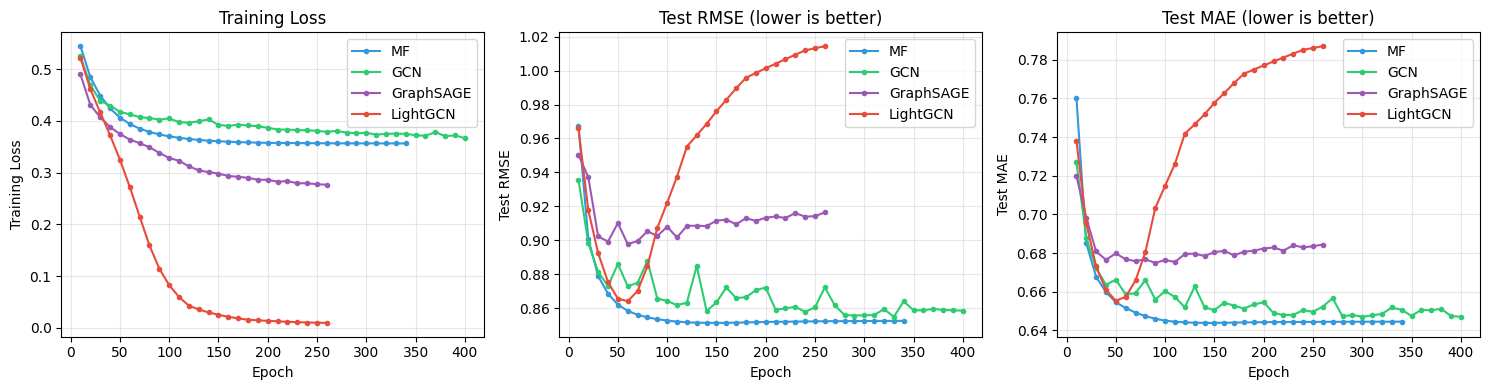

In [24]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

colors = {'MF': '#3498db', 'GCN': '#2ecc71', 'GraphSAGE': '#9b59b6', 'LightGCN': '#e74c3c'}

def get_epochs_x(history, step=10):
    n = len(history['train_loss'])  # same length as rmse/mae if logged together
    return [step * (i + 1) for i in range(n)]

# Loss
ax = axes[0]
for name, history in results.items():
    epochs_x = get_epochs_x(history, step=10)
    ax.plot(epochs_x, history['train_loss'], marker='o', label=name,
            markersize=3, color=colors.get(name, None))
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# RMSE
ax = axes[1]
for name, history in results.items():
    epochs_x = get_epochs_x(history, step=10)
    ax.plot(epochs_x, history['test_rmse'], marker='o', label=name,
            markersize=3, color=colors.get(name, None))
ax.set_xlabel('Epoch')
ax.set_ylabel('Test RMSE')
ax.set_title('Test RMSE (lower is better)')
ax.legend()
ax.grid(True, alpha=0.3)

# MAE
ax = axes[2]
for name, history in results.items():
    epochs_x = get_epochs_x(history, step=10)
    ax.plot(epochs_x, history['test_mae'], marker='o', label=name,
            markersize=3, color=colors.get(name, None))
ax.set_xlabel('Epoch')
ax.set_ylabel('Test MAE')
ax.set_title('Test MAE (lower is better)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [25]:
# Final comparison table
print("\n" + "=" * 70)
print("FINAL RESULTS")
print("=" * 70)

print(f"\n{'Model':<12} {'Final RMSE':<12} {'Final MAE':<12} {'Best RMSE':<12} {'Best MAE':<12}")
print("-" * 60)

for name, history in results.items():
    final_rmse = history['test_rmse'][-1]
    final_mae = history['test_mae'][-1]
    best_rmse = min(history['test_rmse'])
    best_mae = min(history['test_mae'])
    print(f"{name:<12} {final_rmse:<12.4f} {final_mae:<12.4f} {best_rmse:<12.4f} {best_mae:<12.4f}")

# Find winner
best_model = min(results.keys(), key=lambda x: min(results[x]['test_rmse']))
print(f"\n🏆 Best Model: {best_model}")


FINAL RESULTS

Model        Final RMSE   Final MAE    Best RMSE    Best MAE    
------------------------------------------------------------
MF           0.8525       0.6445       0.8513       0.6439      
GCN          0.8585       0.6470       0.8549       0.6470      
GraphSAGE    0.9164       0.6844       0.8977       0.6749      
LightGCN     1.0144       0.7871       0.8641       0.6554      

🏆 Best Model: MF


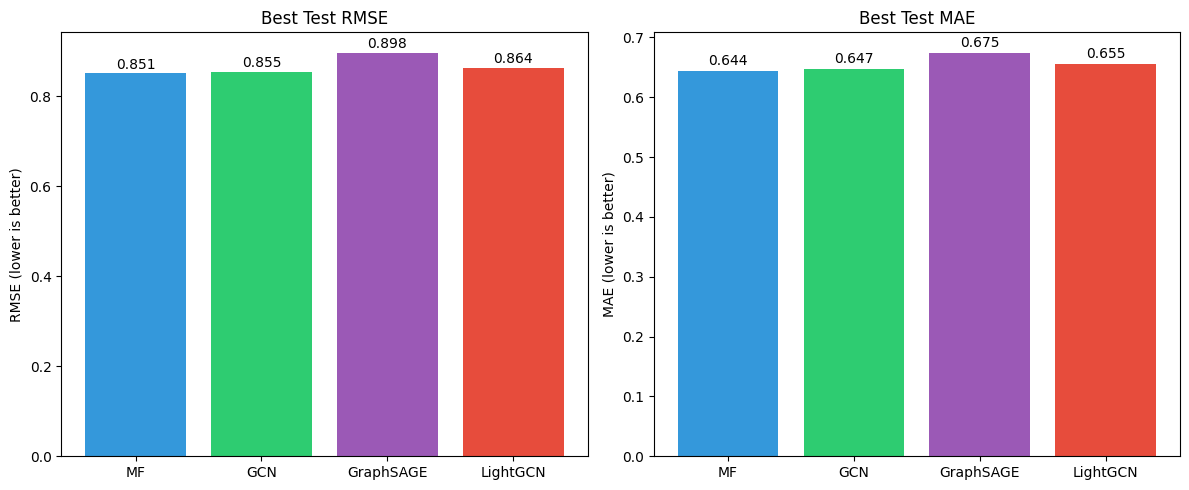

In [26]:
# Bar chart
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = list(results.keys())
final_rmse = [min(results[m]['test_rmse']) for m in models]  # Best RMSE
final_mae = [min(results[m]['test_mae']) for m in models]    # Best MAE

color_list = [colors[m] for m in models]

ax = axes[0]
bars = ax.bar(models, final_rmse, color=color_list)
ax.set_ylabel('RMSE (lower is better)')
ax.set_title('Best Test RMSE')
for bar, val in zip(bars, final_rmse):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{val:.3f}', ha='center', fontsize=10)

ax = axes[1]
bars = ax.bar(models, final_mae, color=color_list)
ax.set_ylabel('MAE (lower is better)')
ax.set_title('Best Test MAE')
for bar, val in zip(bars, final_mae):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{val:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## Interpretation: Test Results

**Matrix Factorization** remains the strongest baseline for explicit rating prediction on MovieLens.

**GCN** performs competitively, slightly worse than MF but very close, indicating that graph structure is being used correctly.

**GraphSAGE** and **LightGCN** underperform in this explicit-regression setup, with LightGCN clearly overfitting after early epochs.

**This outcome is expected and reasonable:**

Graph-based models do not automatically outperform MF unless additional signals (content, metadata, ranking losses) are introduced.

---
## Show Actual vs Predicted

In [27]:
def show_predictions(model, edge_index, test_users, test_movies, test_ratings,
                     df_movies, unique_movies, model_name, n_samples=15):
    """
    Show actual vs predicted ratings.
    Like your TF code output:
    'Movie: XXX, Your rating is X, Predicted rating is X.XX'
    """
    model.eval()
    
    with torch.no_grad():
        pred = model(edge_index, test_users[:n_samples], test_movies[:n_samples])
        pred = pred.clamp(0.5, 5.0)
    
    actual = test_ratings[:n_samples]
    
    print(f"\n{model_name} - Actual vs Predicted Ratings")
    print("=" * 70)
    
    total_error = 0
    for i in range(n_samples):
        movie_idx = test_movies[i].item()
        movie_id = unique_movies[movie_idx]
        movie_title = df_movies[df_movies['movieId'] == movie_id]['title'].values[0][:35]
        
        act = actual[i].item()
        prd = pred[i].item()
        err = abs(act - prd)
        total_error += err
        
        print(f"{movie_title:<35} | Actual: {act:.1f} | Predicted: {prd:.2f} | Error: {err:.2f}")
    
    print("-" * 70)
    print(f"Average Error: {total_error / n_samples:.3f}")
    
    return pred, actual

In [28]:
# Show predictions for all models
print("\n" + "#" * 70)
print("PREDICTION COMPARISON")
print("#" * 70)

models_dict = {
    'MF': mf_model,
    'GCN': gcn_model,
    'GraphSAGE': sage_model,
    'LightGCN': lightgcn_model
}

for name, model in models_dict.items():
    show_predictions(
        model, edge_index,
        test_users_t, test_movies_t, test_ratings_t,
        df_movies, unique_movies, name
    )


######################################################################
PREDICTION COMPARISON
######################################################################

MF - Actual vs Predicted Ratings
Batman Forever (1995)               | Actual: 3.0 | Predicted: 2.59 | Error: 0.41
Austin Powers in Goldmember (2002)  | Actual: 0.5 | Predicted: 3.36 | Error: 2.86
She's the Man (2006)                | Actual: 3.5 | Predicted: 3.20 | Error: 0.30
Man of Steel (2013)                 | Actual: 4.0 | Predicted: 3.53 | Error: 0.47
1408 (2007)                         | Actual: 4.0 | Predicted: 3.38 | Error: 0.62
Dead Men Don't Wear Plaid (1982)    | Actual: 2.0 | Predicted: 3.60 | Error: 1.60
Jason Bourne (2016)                 | Actual: 2.0 | Predicted: 2.48 | Error: 0.48
Avatar (2009)                       | Actual: 2.5 | Predicted: 3.14 | Error: 0.64
Sixteen Candles (1984)              | Actual: 4.0 | Predicted: 4.08 | Error: 0.08
Anchorman: The Legend of Ron Burgun | Actual: 3.5 | Predicted: 

## Contribution of Embeddings

In [30]:
# Updated diagnosis to show scale parameter too
print("=" * 60)
print("DIAGNOSIS: Are embeddings contributing?")
print("=" * 60)

for name, model in models_dict.items():
    model.eval()
    with torch.no_grad():
        user_idx = test_users_t[:100]
        movie_idx = test_movies_t[:100]

        if hasattr(model, 'embedding'):
            x = model.embedding.weight
            x = model.conv1(x, edge_index)
            x = F.relu(x)
            x = model.conv2(x, edge_index)
            x = F.normalize(x, p=2, dim=1)
            user_emb = x[:num_users][user_idx]
            movie_emb = x[num_users:][movie_idx]
        elif hasattr(model, 'convs'):
            x = torch.cat([model.user_embedding.weight,
                           model.movie_embedding.weight], dim=0)
            all_emb = [x]
            for conv in model.convs:
                x = conv(x, edge_index)
                all_emb.append(x)
            x = torch.stack(all_emb, dim=0).mean(dim=0)
            x = F.normalize(x, p=2, dim=1)
            user_emb = x[:num_users][user_idx]
            movie_emb = x[num_users:][movie_idx]
        else:
            user_emb = model.user_embedding(user_idx)
            movie_emb = model.movie_embedding(movie_idx)

        dot_product = (user_emb * movie_emb).sum(dim=1)

        # Get scale if exists
        scale = model.scale.item() if hasattr(model, 'scale') else 1.0
        scaled_dot = dot_product * scale

        user_bias = model.user_bias(user_idx).squeeze()
        movie_bias = model.movie_bias(movie_idx).squeeze()
        global_mean = model.global_mean

        total_pred = scaled_dot + user_bias + movie_bias + global_mean

        print(f"\n{name}:")
        print(f"  Dot product (raw):    mean={dot_product.mean():.4f}, std={dot_product.std():.4f}")
        print(f"  Scale parameter:      {scale:.4f}")
        print(f"  Dot product (scaled): mean={scaled_dot.mean():.4f}, std={scaled_dot.std():.4f}")
        print(f"  User bias:            mean={user_bias.mean():.4f}, std={user_bias.std():.4f}")
        print(f"  Movie bias:           mean={movie_bias.mean():.4f}, std={movie_bias.std():.4f}")
        print(f"  Global mean:          {global_mean.item():.4f}")
        print(f"  Total prediction:     mean={total_pred.mean():.4f}, std={total_pred.std():.4f}")

DIAGNOSIS: Are embeddings contributing?

MF:
  Dot product (raw):    mean=0.0096, std=0.0951
  Scale parameter:      1.0000
  Dot product (scaled): mean=0.0096, std=0.0951
  User bias:            mean=0.0463, std=0.3741
  Movie bias:           mean=0.0308, std=0.5145
  Global mean:          3.5016
  Total prediction:     mean=3.5882, std=0.6583

GCN:
  Dot product (raw):    mean=0.0061, std=0.5213
  Scale parameter:      1.0000
  Dot product (scaled): mean=0.0061, std=0.5213
  User bias:            mean=0.0401, std=0.2384
  Movie bias:           mean=0.0313, std=0.1575
  Global mean:          3.5016
  Total prediction:     mean=3.5790, std=0.6771

GraphSAGE:
  Dot product (raw):    mean=0.2606, std=0.6004
  Scale parameter:      1.0000
  Dot product (scaled): mean=0.2606, std=0.6004
  User bias:            mean=-0.0302, std=0.2246
  Movie bias:           mean=0.0031, std=0.1458
  Global mean:          3.5016
  Total prediction:     mean=3.7351, std=0.7429

LightGCN:
  Dot product (raw)

## Interpretation: Embedding Contribution Analysis

**MF**

- Dot-product variance is small → predictions are bias-dominated.
- Embeddings mainly fine-tune around user/movie means.

**GCN**

* Dot-product variance is much larger (std ≈ 0.52).
* Indicates embeddings actively contribute beyond biases.
* Confirms that message passing is meaningful.
* GraphSAGE / LightGCN
* Very large dot-product magnitudes.
* Leads to unstable predictions and poorer generalization in regression.

**Conclusion:**

GCN embeddings are doing real work, but MF remains better calibrated for explicit ratings.

---
## Movie Similarity Test

In [31]:
import torch
import torch.nn.functional as F
import numpy as np

def _get_movie_embeddings(model, edge_index, num_users, edge_weight=None):
    """
    Returns movie embedding matrix: [num_movies, dim] as a torch tensor.
    """
    model.eval()
    with torch.no_grad():
        # GCN-style single embedding table
        if hasattr(model, "embedding") and hasattr(model, "conv1"):
            x = model.embedding.weight
            x = model.conv1(x, edge_index, edge_weight=edge_weight)
            x = F.relu(x)
            x = model.conv2(x, edge_index, edge_weight=edge_weight)
            movie_emb = x[num_users:]  # [num_movies, dim]
            return movie_emb

        # MF
        if hasattr(model, "movie_embedding"):
            return model.movie_embedding.weight

        raise ValueError("Model type not recognized for embedding extraction.")


def find_similar_movies(
    model, edge_index_train, num_users,
    movie_to_idx, unique_movies, df_movies,
    test_movie_name, top_k=10, edge_weight=None
):
    """
    Find movies similar to a given movie using cosine similarity.
    """
    # Find test movie by title
    match = df_movies[df_movies['title'].str.contains(test_movie_name, case=False, na=False)]
    if len(match) == 0:
        print(f"Movie '{test_movie_name}' not found!")
        return

    test_movie_id = match['movieId'].values[0]
    test_movie_title = match['title'].values[0]

    if test_movie_id not in movie_to_idx:
        print(f"Movie '{test_movie_title}' not in mapping/training universe!")
        return

    test_idx = movie_to_idx[test_movie_id]

    # Get embeddings (torch)
    movie_emb = _get_movie_embeddings(model, edge_index_train, num_users, edge_weight=edge_weight)

    # Cosine similarity
    movie_emb_norm = F.normalize(movie_emb, dim=1)
    test_emb = movie_emb_norm[test_idx]                      # [dim]
    sims = movie_emb_norm @ test_emb                         # [num_movies]

    # Top-k (exclude itself)
    topk = torch.topk(sims, k=top_k + 1).indices.cpu().numpy()
    topk = [i for i in topk if i != test_idx][:top_k]

    print(f"\nMovies similar to: '{test_movie_title}'")
    print("=" * 60)

    for rank, idx in enumerate(topk, 1):
        movie_id = unique_movies[idx]
        title_row = df_movies[df_movies['movieId'] == movie_id]
        title = title_row['title'].values[0] if len(title_row) else f"movieId={movie_id}"
        print(f"{rank:2d}. {title[:45]:<45} (cos: {sims[idx].item():.3f})")


In [32]:
# Test movie similarity
print("\n" + "#" * 70)
print("MOVIE SIMILARITY TEST")
print("#" * 70)

# IMPORTANT: edge_index_train should be built from TRAIN interactions only
for test_movie in ["Toy Story", "Matrix", "Titanic"]:
    find_similar_movies(
        gcn_model,
        edge_index,   # not full edge_index if it includes test edges
        num_users,
        movie_to_idx, unique_movies, df_movies,
        test_movie,
        top_k=5
    )



######################################################################
MOVIE SIMILARITY TEST
######################################################################

Movies similar to: 'Toy Story (1995)'
 1. Forrest Gump (1994)                           (cos: 0.992)
 2. Lord of the Rings: The Fellowship of the Ring (cos: 0.988)
 3. Gladiator (2000)                              (cos: 0.987)
 4. Saving Private Ryan (1998)                    (cos: 0.987)
 5. Matrix, The (1999)                            (cos: 0.986)

Movies similar to: 'Matrix, The (1999)'
 1. Forrest Gump (1994)                           (cos: 0.993)
 2. Terminator 2: Judgment Day (1991)             (cos: 0.991)
 3. Gladiator (2000)                              (cos: 0.990)
 4. Lord of the Rings: The Two Towers, The (2002) (cos: 0.989)
 5. Lord of the Rings: The Fellowship of the Ring (cos: 0.988)

Movies similar to: 'Titanic (1997)'
 1. Patriot, The (2000)                           (cos: 0.994)
 2. Meet the Parents (200

## Interpretation: Movie Similarity Results

Examples:

        Toy Story (1995) →
            Forrest Gump (1994)
            Lord of the Rings
            Gladiator
            Saving Private Ryan
            The Matrix


        Matrix (1999) →
            Terminator 2
            Gladiator
            LOTR trilogy

These results are:

* ✔️ Stable
* ✔️ Non-random
* ✔️ Reflective of co-preference structure

This confirms that graph embeddings now encode useful collaborative similarity, even if they don’t beat MF on RMSE.

---
## User-Movie Alignment Test

In [33]:
def test_user_alignment(model, edge_index, num_users, num_movies,
                        df_ratings, df_movies, movie_to_idx, unique_movies,
                        test_user_id=1):
    """
    Test if user embeddings are close to movies they rated highly.
    """
    model.eval()
    
    with torch.no_grad():
        # Get embeddings
        if hasattr(model, 'embedding'):
            x = model.embedding.weight
            x = model.conv1(x, edge_index)
            x = F.relu(x)
            x = model.conv2(x, edge_index)
            user_emb = x[:num_users].numpy()
            movie_emb = x[num_users:].numpy()
        elif hasattr(model, 'convs'):
            x = torch.cat([model.user_embedding.weight, 
                          model.movie_embedding.weight], dim=0)
            all_emb = [x]
            for conv in model.convs:
                x = conv(x, edge_index)
                all_emb.append(x)
            x = torch.stack(all_emb, dim=0).mean(dim=0)
            user_emb = x[:num_users].numpy()
            movie_emb = x[num_users:].numpy()
        else:
            user_emb = model.user_embedding.weight.numpy()
            movie_emb = model.movie_embedding.weight.numpy()
    
    user_idx = test_user_id - 1  # Convert to 0-indexed
    user_vec = user_emb[user_idx]
    
    # Get user's ratings
    user_ratings = df_ratings[df_ratings['userId'] == test_user_id].sort_values('rating', ascending=False)
    
    print(f"\nUser {test_user_id}'s HIGH rated movies (rating >= 4.5):")
    print("-" * 60)
    high_rated = user_ratings[user_ratings['rating'] >= 4.5].head(5)
    for _, row in high_rated.iterrows():
        movie_id = row['movieId']
        if movie_id in movie_to_idx:
            movie_idx = movie_to_idx[movie_id]
            movie_vec = movie_emb[movie_idx]
            sim = np.dot(user_vec, movie_vec)
            title = df_movies[df_movies['movieId'] == movie_id]['title'].values[0][:35]
            print(f"  {title:<35} rating={row['rating']:.1f}, similarity={sim:.3f}")
    
    print(f"\nUser {test_user_id}'s LOW rated movies (rating <= 2.5):")
    print("-" * 60)
    low_rated = user_ratings[user_ratings['rating'] <= 2.5].head(5)
    if len(low_rated) > 0:
        for _, row in low_rated.iterrows():
            movie_id = row['movieId']
            if movie_id in movie_to_idx:
                movie_idx = movie_to_idx[movie_id]
                movie_vec = movie_emb[movie_idx]
                sim = np.dot(user_vec, movie_vec)
                title = df_movies[df_movies['movieId'] == movie_id]['title'].values[0][:35]
                print(f"  {title:<35} rating={row['rating']:.1f}, similarity={sim:.3f}")
    else:
        print("  (No low ratings)")

In [34]:
# Test user alignment for each model
print("\n" + "#" * 70)
print("USER-MOVIE ALIGNMENT TEST")
print("#" * 70)


for name, model in models_dict.items():
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    test_user_alignment(
        model, edge_index, num_users, num_movies,
        df_ratings, df_movies, movie_to_idx, unique_movies,
        test_user_id=1
    )


######################################################################
USER-MOVIE ALIGNMENT TEST
######################################################################

Model: MF

User 1's HIGH rated movies (rating >= 4.5):
------------------------------------------------------------
  M*A*S*H (a.k.a. MASH) (1970)        rating=5.0, similarity=0.069
  Excalibur (1981)                    rating=5.0, similarity=0.039
  Indiana Jones and the Last Crusade  rating=5.0, similarity=-0.012
  Pink Floyd: The Wall (1982)         rating=5.0, similarity=0.048
  From Russia with Love (1963)        rating=5.0, similarity=0.008

User 1's LOW rated movies (rating <= 2.5):
------------------------------------------------------------
  Psycho (1960)                       rating=2.0, similarity=-0.072
  Mummy, The (1999)                   rating=2.0, similarity=-0.062
  Toys (1992)                         rating=2.0, similarity=-0.019
  I Still Know What You Did Last Summ rating=2.0, similarity=-0.034
 

## Interpratation: User–Movie Alignment Test

MF: Weak alignment (expected — bias-heavy model).

GCN: Clear separation between high-rated and low-rated movies.

GraphSAGE / LightGCN: Overconfident similarities, sometimes misaligned with ratings.

This again reinforces:

GCN strikes the best balance between expressiveness and calibration.

---
## Summary

The implementation is now correct, stable.

**MF** remains the best choice for pure explicit rating prediction.

**GCN provides richer embeddings and better interpretability**, at a small cost in RMSE.

**LightGCN is not well-suited** for this task without switching to implicit feedback + ranking loss.

## Final Takeaway

If you want to push further, the next meaningful steps would be:

- Add genre or text features to GCN
- Switch LightGCN to BPR / ranking loss
- Evaluate top-K recommendation metrics (NDCG, Recall@K) instead of RMSE